#IE716 Project
---

##Libraries:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer
import random
import math
import itertools
import sys

---
##General functions:


###Function for creating a dataset: 

In [ ]:
#Creating TSP dataset: 
def create_TSP_dataset(n):
  points = []
  map = [[],[]]
  for i in range(0,n):
    point = []
    for j in range(2):
      point.append(round(random.uniform(0,1000),2))
    points.append(point)
  for x in points:
    map[0].append(x[0])
    map[1].append(x[1]) 
  dataset =  []
  for i in points:
    dataset.append([])
    for j in points:
      distance = 0
      for k in range(len(j)):
        distance += (i[k]-j[k])**2
      distance = round(distance**(1/2),2)
      dataset[-1].append(distance)
  
  return np.array(dataset), map

###Function for plotting TSP solution:

In [ ]:
def TSP_plot(path, map, title):
  plt.figure(figsize=(7,7))
  plt.scatter(map[0], map[1])
  for i in range(-1,len(path)-1):
    plt.arrow(map[0][path[i]],map[1][path[i]],(map[0][path[i+1]]-map[0][path[i]]),(map[1][path[i+1]]-map[1][path[i]]))
  plt.title(title)
  plt.show()

###Function for calculating total cost:

In [ ]:
def find_cost(path, DS):
  n = DS.shape[0]
  cost = 0
  for i in range(-1,n-1):
    cost += DS[path[i]][path[i+1]]
  return round(cost,2)


##Function for extracting cost matrix from .tsp file 
**Note: Convert and save the .tsp file as .txt**

In [ ]:
def extract_cost_matrix(filename):
  DS =  []
  key_1, key_2, key_3 = 'DIMENSION', 'EDGE_WEIGHT_SECTION', 'EOF'
  f = open(filename, "r")
  count, row, col = 0,0,0
  for x in f:
    if key_1 in x or key_2 in x or key_3 in x:
      count += 1
    if count == 1:
      number_of_cities = int(x.replace(key_1+': ',''))
      for i in range(number_of_cities):
        EM = []
        for j in range(number_of_cities):
          EM.append(None)
        DS.append(EM)
      count += 1
    if count == 4:
      if int(x) == 0:
        DS[row][col] = int(x)
        row += 1
        col = 0
      else: 
        DS[row][col] = int(x)
        DS[col][row] = int(x)
        col += 1
    if count == 3:
      count += 1
    if count == 5:
      break
  
  return np.array(DS)

In [ ]:
def extract_cost_matrix_nodes(filename):
  DS =  []
  map = [[],[]]
  key_1, key_2, key_3 = 'DIMENSION', 'NODE_COORD_SECTION', 'EOF'
  f = open(filename, "r")
  count = 0
  for x in f:
    if key_1 in x or key_2 in x or key_3 in x:
      count += 1
    if count == 1:
      y = x.replace('\n','')
      z = y.replace(key_1,'')
      number_of_cities = int(z.replace(':',''))
      for i in range(number_of_cities):
        EM = []
        for j in range(number_of_cities):
          EM.append(None)
        DS.append(EM)
      count += 1
    if count == 4:
      data = x.split(' ')
      map[0].append(float(data[1]))
      map[1].append(float(data[2])) 
    if count == 3:
      count += 1
    if count == 5:
      break
  # for _ in range(number_of_cities):
  #   DS.append([])
  #   for __ in range(number_of_cities):
  #     DS[-1].append(None)
  
  for i in range(0,number_of_cities):
    for j in range(0, number_of_cities):
      DS[i][j] = round(((map[0][i]-map[0][j])**2 + (map[1][i]-map[1][j])**2)**(1/2),4)
      DS[j][i] = round(((map[0][i]-map[0][j])**2 + (map[1][i]-map[1][j])**2)**(1/2),4)

  return np.array(DS), map

---
##Ant Colony Optimization algorithm: (ACS, EAS, MMAS)

In [ ]:
class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='ACS', colony_size=10, initial_path_weight=0.00001, elitist_weight=0.1, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, DS = None, labels=None, global_best_tour = None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.DS = DS
        self.num_nodes = self.DS.shape[0]
        self.initial_path_weight = initial_path_weight
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
          for j in range(i+1, self.num_nodes):
            self.edges[i][j] = self.edges[j][i] = self.Edge(i,j,self.DS[i][j], initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        if global_best_tour is not None:
          self.global_best_tour = global_best_tour
          self.global_best_distance = find_cost(global_best_tour, self.DS)
          self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.initial_path_weight)
        else:
          self.global_best_distance = float("inf")

        
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)

        self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.initial_path_weight)

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance

            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
        return self.global_best_tour

##Nearest neighbour algorithm for TSP:

In [ ]:
def nearest_neighbour(DS):
  n =  DS.shape[0]  
  path = [0]
  cities = []
  for i in range(1,n):
    cities.append(i)
  for i in range(n-1):
    target = cities[0]
    sd = DS[path[-1]][target]
    for c in cities:
      if DS[path[-1]][c] < sd:
        target = c
        sd = DS[path[-1]][c]
    path.append(target)
    cities.remove(target)
  return path

##2-opt search:

Two-opt: **(x, x+1), (y, y+1) --> (x,y), (x+1,y+1)** (And reverse order of others in between)

In [ ]:
def search_2opt(DS, path, iter):
  N = DS.shape[0]
  prev_best = find_cost(path, DS)
  c = 0
  c2 = 0
  while(1):
    for i in range(-1,N-1):
      for j in range(i+1,N):
        new_path = path.copy()
        r = (j-i+1)//2
        for k in range(0,r):
          new_path[i+k], new_path[j-k] = new_path[j-k], new_path[i+k]
        if find_cost(new_path, DS) < find_cost(path, DS):
          path = new_path.copy()
    current_best = find_cost(path, DS)
    if current_best < prev_best:
      prev_best = current_best
      c2 = 0
    else:
      c2 += 1
    c+=1
    if c>=iter:
      return path
    if c2>1:
      return path

---
##Application:

In [ ]:
number_of_cities = 30
random.seed(number_of_cities)
DS, map = create_TSP_dataset(number_of_cities)
random_path = random.sample(range(number_of_cities),number_of_cities)

In [ ]:
print(DS)
print(map)

[[   0.    626.05  330.61  379.87  481.62  837.39  367.08  670.26  631.16
   566.53  221.6   729.49  492.09  385.61  614.12  474.07  587.03  340.04
   461.04  530.29  478.51  334.24  501.27  574.05  469.97  801.04  445.96
   645.55  287.38  416.18]
 [ 626.05    0.    435.31  367.36  977.83 1021.33  618.68  228.7   627.65
   942.13  773.69  151.79  651.18  535.99  654.85  178.94  329.84  937.43
   413.49  307.31  391.7   300.44  156.55  526.34  928.09  286.19  932.22
   534.2   456.56  665.53]
 [ 330.61  435.31    0.    427.47  805.14 1074.47  187.5   586.76  766.54
   859.42  376.45  578.88  684.96  547.76  768.58  256.72  580.59  667.09
   130.43  522.93  531.57  281.55  388.82  677.01  783.8   694.61  766.19
   729.35   43.69  640.24]
 [ 379.87  367.36  427.47    0.    618.4   691.92  589.54  310.55  342.13
   575.11  590.31  407.98  300.41  171.52  350.21  321.14  207.36  618.09
   509.01  152.38  109.04  152.15  210.86  249.62  564.5   442.31  572.63
   304.11  411.8   299.9 ]
 [ 4

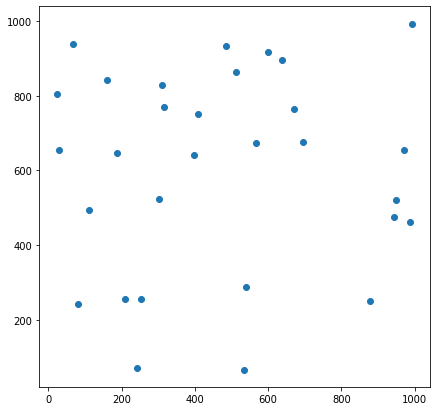

In [ ]:
plt.figure(figsize = (7,7))
plt.scatter(map[0],map[1])
plt.show()

In [ ]:
path_NN = nearest_neighbour(DS)
find_cost(path_NN, DS)

4980.75

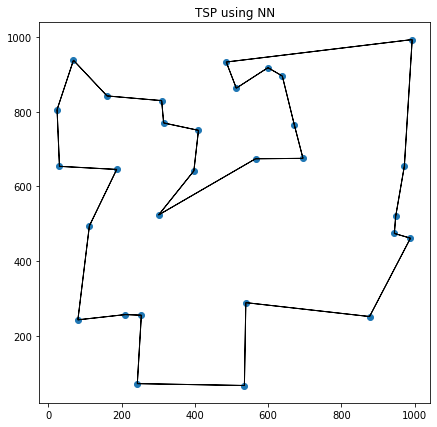

In [ ]:
TSP_plot(path_NN, map,"TSP using NN")

##2-Opt applied: 


In [ ]:
path_2opt = random_path
print(find_cost(random_path, DS))
path_2opt = search_2opt(DS,path_2opt, iter =10000000)
print(find_cost(path_2opt, DS))

24524.99
5803.92


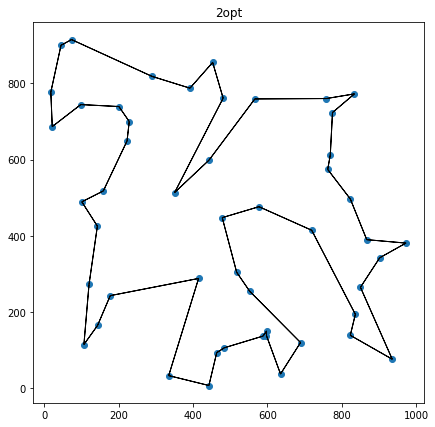

In [ ]:
TSP_plot(path_2opt, map,"2opt")

##NN+2opt applied:

In [ ]:
path_2opt_NN = search_2opt(DS,path_NN,iter=1000)
print(find_cost(path_2opt_NN, DS))

5423.8


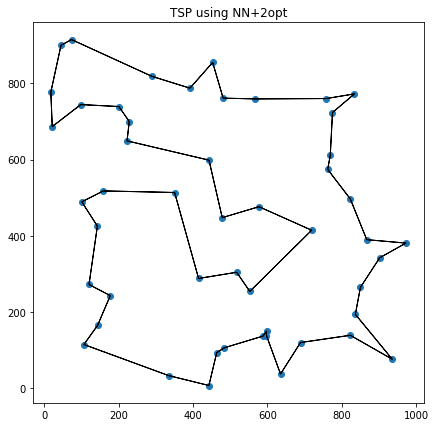

In [ ]:
TSP_plot(path_2opt_NN, map,"TSP using NN+2opt")

##ACO applied:

##Comparison of ACO convergence:

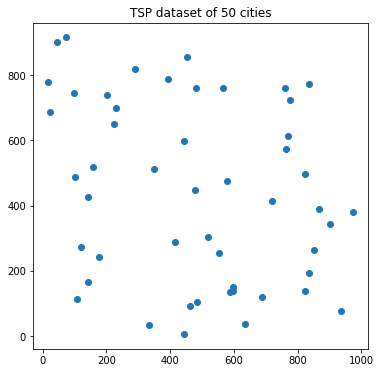

In [ ]:
DS, map = create_TSP_dataset(50)
plt.figure(figsize=(6,6))
plt.scatter(map[0],map[1])
plt.title("TSP dataset of 50 cities")
plt.show()

In [ ]:
ACS_cost = []
EAS_cost = []
MMAS_cost =  []
n = 1000
steps = [i for i in range(1,n+1)]
acs = SolveTSPUsingACO(mode='ACS', colony_size=5, steps=1, DS=DS)
eas = SolveTSPUsingACO(mode='Elitist', colony_size=5, steps=1, DS=DS)
mmas = SolveTSPUsingACO(mode='Minmax', colony_size=5, steps=1, DS=DS)

for step in range(n):
  path_ACS = acs.run()
  ACS_cost.append(find_cost(path_ACS,DS))
  path_EAS = eas.run()
  EAS_cost.append(find_cost(path_EAS,DS))
  path_MMAS = mmas.run()
  MMAS_cost.append(find_cost(path_MMAS,DS))


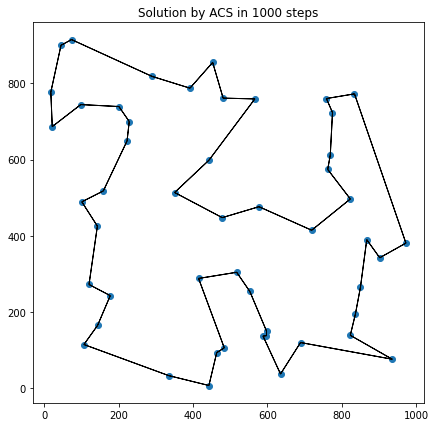

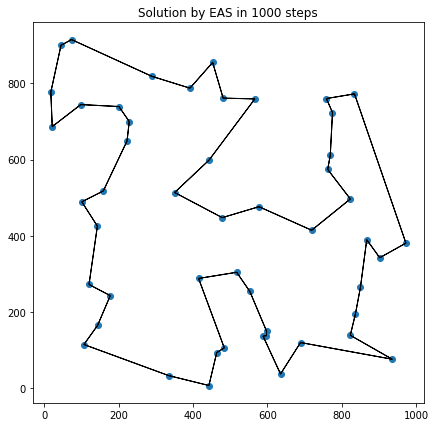

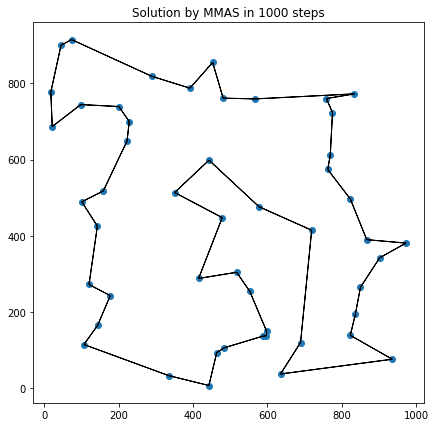

In [ ]:
TSP_plot(path_ACS, map, 'Solution by ACS in 1000 steps')
TSP_plot(path_EAS, map, 'Solution by EAS in 1000 steps')
TSP_plot(path_MMAS, map, 'Solution by MMAS in 1000 steps')

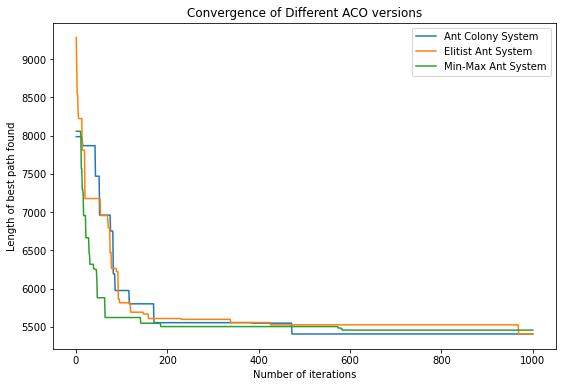

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(steps, ACS_cost, label = 'Ant Colony System')
plt.plot(steps, EAS_cost, label = 'Elitist Ant System')
plt.plot(steps, MMAS_cost, label = 'Min-Max Ant System')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Length of best path found')
plt.title("Convergence of Different ACO versions")
plt.show()

In [ ]:
find_cost(path_ACS,DS)

5405.74

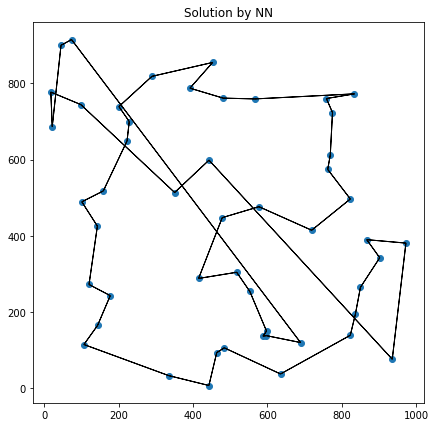

In [ ]:
random_path = random.sample(range(50),50)
path_NN = nearest_neighbour(DS)
TSP_plot(path_NN,map,'Solution by NN')

24524.99
5803.92


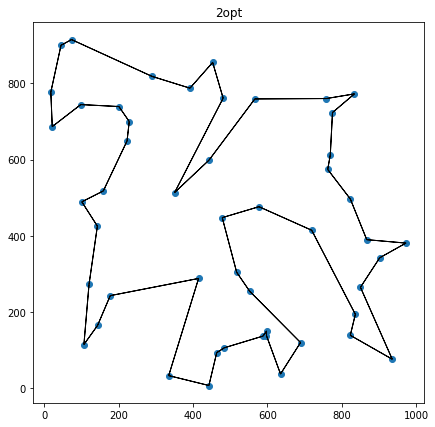

In [ ]:
print(find_cost(random_path, DS))
path_2opt = search_2opt(DS,random_path, iter =10000000)
print(find_cost(path_2opt, DS))
TSP_plot(path_2opt, map,"2opt")

5423.8


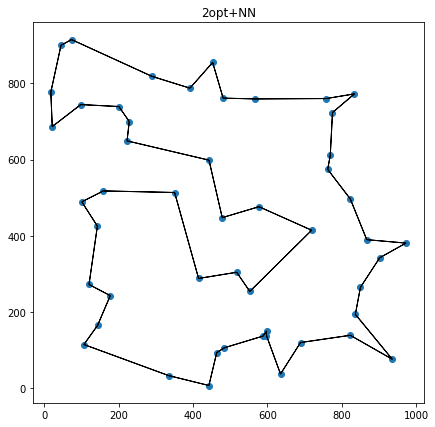

In [ ]:
path_2opt = search_2opt(DS,path_NN, iter =10000000)
print(find_cost(path_2opt, DS))
TSP_plot(path_2opt, map,"2opt+NN")

Cost =  5425.19


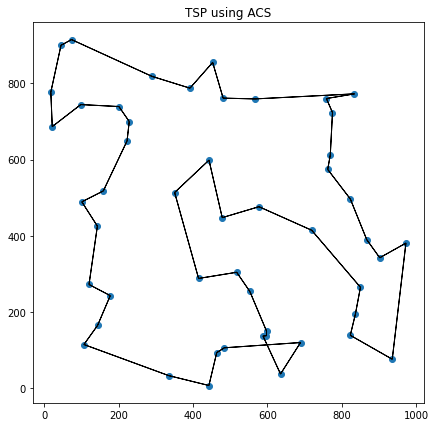

In [ ]:
acs = SolveTSPUsingACO(mode='ACS', colony_size=5, steps=200, DS=DS, global_best_tour = path_NN)
path_ACS = acs.run()
print("Cost = ", find_cost(path_ACS, DS))
TSP_plot(path_ACS, map,"TSP using ACS")

Cost =  5446.14


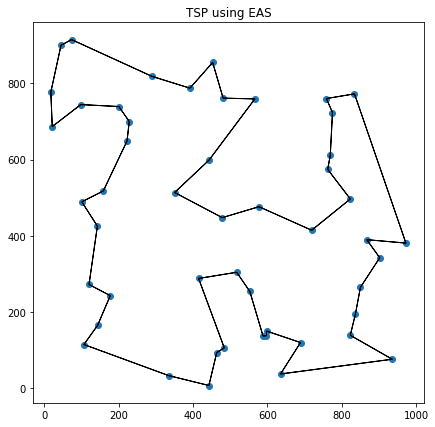

In [ ]:
elitist = SolveTSPUsingACO(mode='Elitist', colony_size=5, steps=500, DS=DS, global_best_tour = path_NN)
path_elitist = elitist.run()
print("Cost = ", find_cost(path_elitist, DS))
TSP_plot(path_elitist, map,"TSP using EAS")

Cost =  6136.01


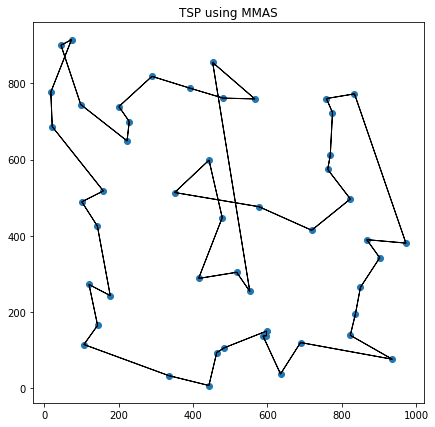

In [ ]:
max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=5, steps=50, DS=DS, global_best_tour= path_NN)
path_minmax = max_min.run()
print("Cost = ", find_cost(path_minmax, DS))
TSP_plot(path_minmax, map,"TSP using MMAS")

In [ ]:
path_2opt = search_2opt(DS, path_elitist,iter=100)
print(find_cost(path_2opt, DS))

5312.23


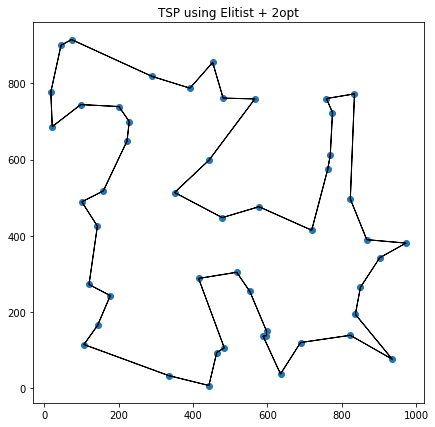

In [ ]:
TSP_plot(path_2opt, map,"TSP using Elitist + 2opt")

Cost =  5312.23


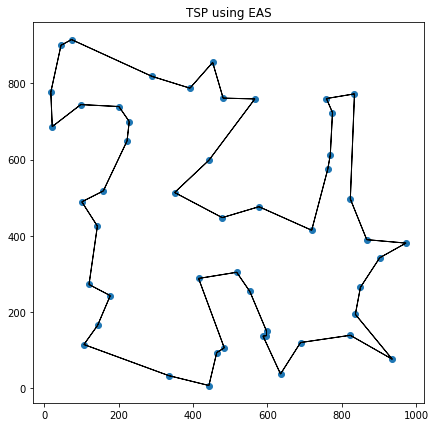

In [ ]:
ACS_2 = SolveTSPUsingACO(mode='elitist', colony_size=10, steps=50, DS=DS, global_best_tour = path_2opt)
path_ACS_2 = ACS_2.run()
print("Cost = ", find_cost(path_ACS_2, DS))
TSP_plot(path_ACS_2, map,"TSP using EAS")

##Fri26 dataset:
Number of nodes = **26** \\
optimal solution = **937**

In [ ]:
DS_fri26 = extract_cost_matrix('fri26.txt')
DS_fri26

array([[  0,  83,  93, 129, 133, 139, 151, 169, 135, 114, 110,  98,  99,
         95,  81, 152, 159, 181, 172, 185, 147, 157, 185, 220, 127, 181],
       [ 83,   0,  40,  53,  62,  64,  91, 116,  93,  84,  95,  98,  89,
         68,  67, 127, 156, 175, 152, 165, 160, 180, 223, 268, 179, 197],
       [ 93,  40,   0,  42,  42,  49,  59,  81,  54,  44,  58,  64,  54,
         31,  36,  86, 117, 135, 112, 125, 124, 147, 193, 241, 157, 161],
       [129,  53,  42,   0,  11,  11,  46,  72,  65,  70,  88, 100,  89,
         66,  76, 102, 142, 156, 127, 139, 155, 180, 228, 278, 197, 190],
       [133,  62,  42,  11,   0,   9,  35,  61,  55,  62,  82,  95,  84,
         62,  74,  93, 133, 146, 117, 128, 148, 173, 222, 272, 194, 182],
       [139,  64,  49,  11,   9,   0,  39,  65,  63,  71,  90, 103,  92,
         71,  82, 100, 141, 153, 124, 135, 156, 181, 230, 280, 202, 190],
       [151,  91,  59,  46,  35,  39,   0,  26,  34,  52,  71,  88,  77,
         63,  78,  66, 110, 119,  88,  98, 13

In [ ]:
#NN 
path_fri26_NN = nearest_neighbour(DS_fri26)
print(find_cost(path_fri26_NN, DS_fri26))

1112


In [ ]:
#NN + 2 opt
path_fri26_2ONN = search_2opt(DS_fri26, path_fri26_NN, 10000)
print(find_cost(path_fri26_2ONN, DS_fri26))

953


In [ ]:
##Initiating the system object with path found using NN as global best tour:
elitist = SolveTSPUsingACO(mode='Elitist', colony_size=10, steps=10, DS=DS_fri26, global_best_tour = path_fri26_NN)
random.seed(26)

**Now run the code below multiple times:**

In [ ]:
path_fri26_elitist = elitist.run()
print("NN + Elitist ACO: Cost = ", find_cost(path_fri26_elitist, DS_fri26))
path_fri26_elitist_2opt = search_2opt(DS_fri26, path_fri26_elitist, 10000)
print("NN + Elitist ACO + 2opt search: Cost = ", find_cost(path_fri26_elitist_2opt, DS_fri26))

NN + Elitist ACO: Cost =  937
NN + Elitist ACO + 2opt search: Cost =  937


##Berlin52 dataset:
Number of nodes = **52** \\
Best solution =  **7542**

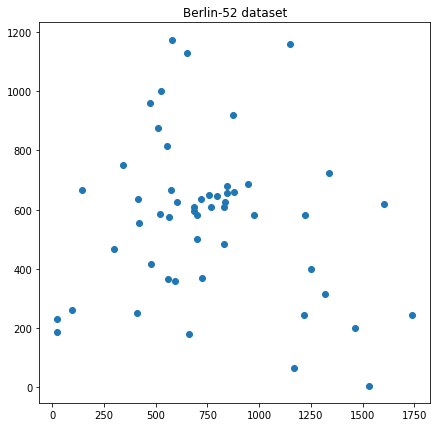

In [ ]:
DS_berlin52, map_berlin52 = extract_cost_matrix_nodes('berlin52.txt')
plt.figure(figsize = (7,7))
plt.scatter(map_berlin52[0], map_berlin52[1])
plt.title("Berlin-52 dataset")
plt.show()

8980.92


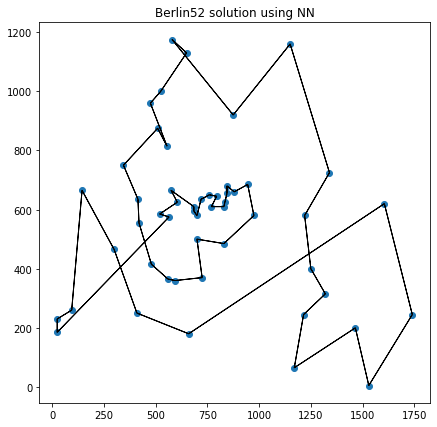

In [ ]:
path_berlin52_NN = nearest_neighbour(DS_berlin52)
print(find_cost(path_berlin52_NN, DS_berlin52))
TSP_plot(path_berlin52_NN, map_berlin52, "Berlin52 solution using NN")

8114.35


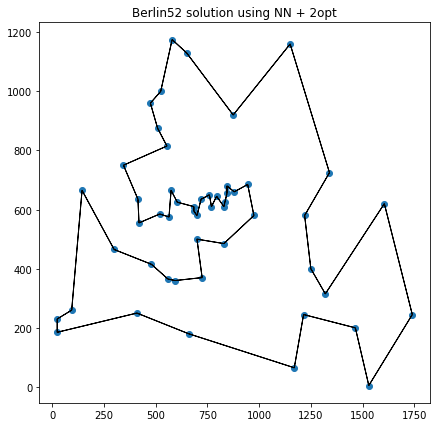

In [ ]:
path_berlin52_2ONN = search_2opt(DS_berlin52, path_berlin52_NN, 10000)
print(find_cost(path_berlin52_2ONN, DS_berlin52))
TSP_plot(path_berlin52_2ONN, map_berlin52, "Berlin52 solution using NN + 2opt")

In [ ]:
elitist = SolveTSPUsingACO(mode='Elitist', colony_size=10, steps=25, DS=DS_berlin52, global_best_tour = path_berlin52_NN)
random.seed(52)

NN + Elitist ACO: Cost =  8012.58


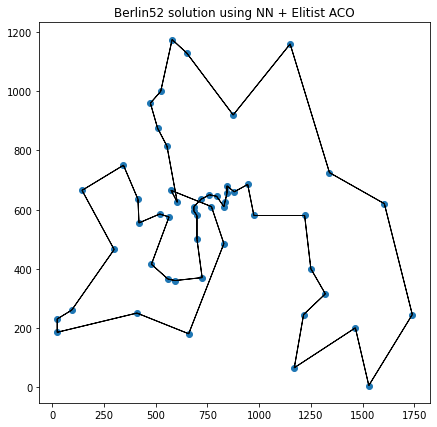

NN + Elitist ACO + 2opt search: Cost =  7811.57


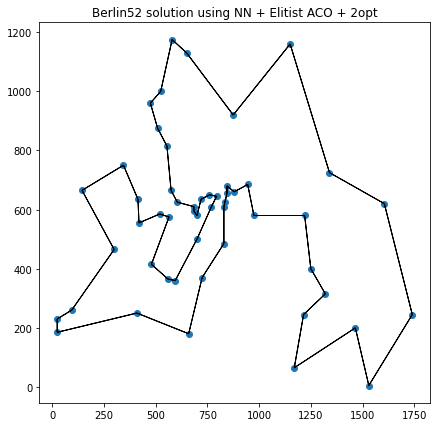

In [ ]:
path_berlin52_elitist = elitist.run()
print("NN + Elitist ACO: Cost = ", find_cost(path_berlin52_elitist, DS_berlin52))
TSP_plot(path_berlin52_elitist, map_berlin52, "Berlin52 solution using NN + Elitist ACO")

path_berlin52_elitist_2opt = search_2opt(DS_berlin52, path_berlin52_elitist, 10000)
print("NN + Elitist ACO + 2opt search: Cost = ", find_cost(path_berlin52_elitist_2opt, DS_berlin52))
TSP_plot(path_berlin52_elitist_2opt, map_berlin52, "Berlin52 solution using NN + Elitist ACO + 2opt")
end =timer()

##Eil101 dataset:
Number of nodes = **101** \\
Best solution =  **639**

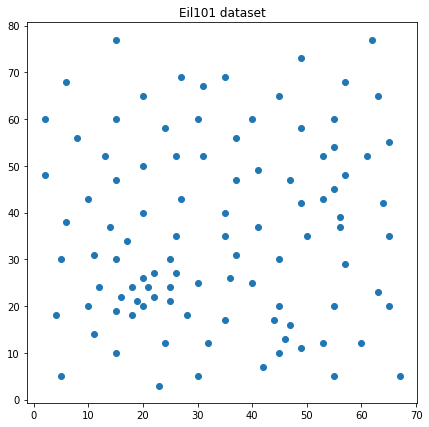

In [ ]:
DS_eil101, map_eil101 = extract_cost_matrix_nodes('eil101.txt')
plt.figure(figsize = (7,7))
plt.scatter(map_eil101[0], map_eil101[1])
plt.title("Eil101 dataset")
plt.show()

cost = 825.24


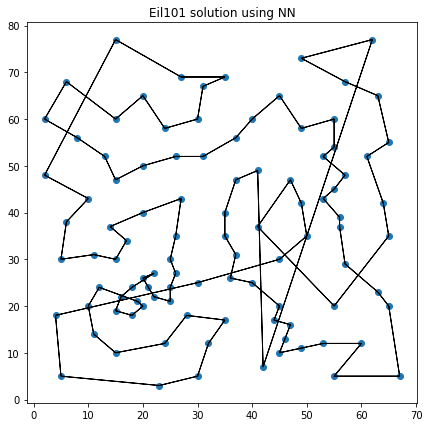

In [ ]:
path_eil101_NN = nearest_neighbour(DS_eil101)
print('cost =',find_cost(path_eil101_NN, DS_eil101))
TSP_plot(path_eil101_NN, map_eil101, "Eil101 solution using NN")

cost =  690.88


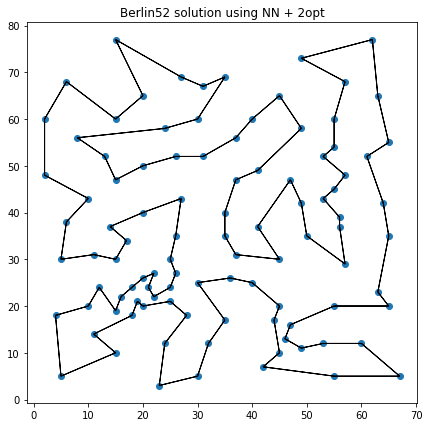

In [ ]:
path_eil101_2ONN = search_2opt(DS_eil101, path_eil101_NN, 10000)
print('cost = ',find_cost(path_eil101_2ONN, DS_eil101))
TSP_plot(path_eil101_2ONN, map_eil101, "Berlin52 solution using NN + 2opt")

In [ ]:
elitist = SolveTSPUsingACO(mode='Elitist', colony_size=15, steps=10, DS=DS_eil101, global_best_tour = path_eil101_NN, elitist_weight = 1.0, rho=0.3, alpha = 8, beta = 3.0)
random.seed(101) 

NN + Elitist ACO: Cost =  716.14 




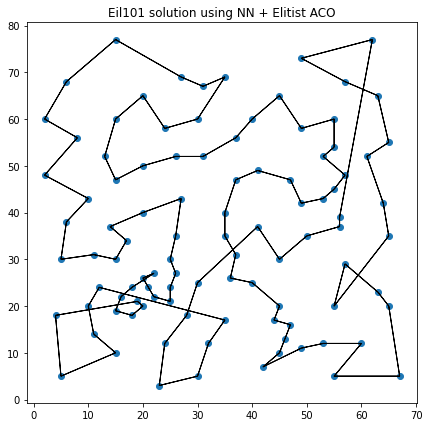

NN + Elitist ACO + 2opt search: Cost =  653.74 




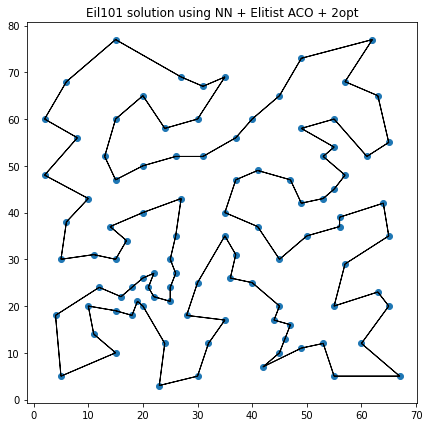

In [ ]:
path_eil101_elitist = elitist.run()
print("NN + Elitist ACO: Cost = ", find_cost(path_eil101_elitist, DS_eil101),"\n\n")
TSP_plot(path_eil101_elitist, map_eil101, "Eil101 solution using NN + Elitist ACO")

path_eil101_elitist_2opt = search_2opt(DS_eil101, path_eil101_elitist, 10000)
print("NN + Elitist ACO + 2opt search: Cost = ", find_cost(path_eil101_elitist_2opt, DS_eil101),"\n\n")
TSP_plot(path_eil101_elitist_2opt, map_eil101, "Eil101 solution using NN + Elitist ACO + 2opt")


##CH-150 dataset:
Number of nodes = **150** \\
Best solution =  **6528**

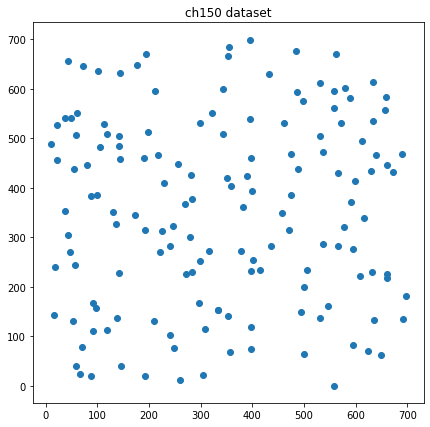

In [ ]:
DS_ch150, map_ch150 = extract_cost_matrix_nodes('ch150.txt')
plt.figure(figsize = (7,7))
plt.scatter(map_ch150[0], map_ch150[1])
plt.title("ch150 dataset")
plt.show()

cost = 8194.61


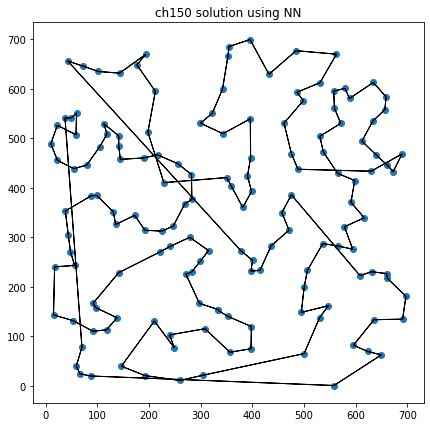

In [ ]:
path_ch150_NN = nearest_neighbour(DS_ch150)
print('cost =',find_cost(path_ch150_NN, DS_ch150))
TSP_plot(path_ch150_NN, map_ch150, "ch150 solution using NN")

cost = 6837.27


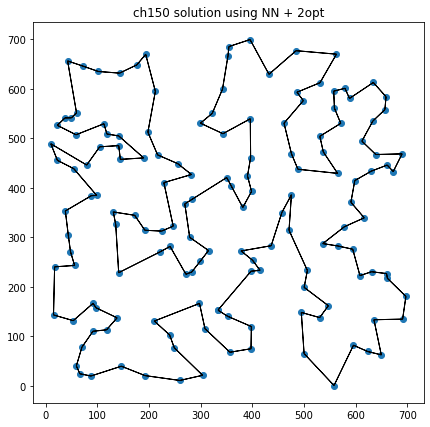

In [ ]:
path_ch150_2ONN = search_2opt(DS_ch150, path_ch150_NN, 10000)
print('cost =',find_cost(path_ch150_2ONN, DS_ch150))
TSP_plot(path_ch150_2ONN, map_ch150, "ch150 solution using NN + 2opt")

In [ ]:
elitist = SolveTSPUsingACO(mode='Elitist', colony_size=10, steps=10, DS=DS_ch150, global_best_tour = path_ch150_NN, rho = 0.3, alpha = 8)
random.seed(150)

NN + Elitist ACO: Cost =  6982.16 




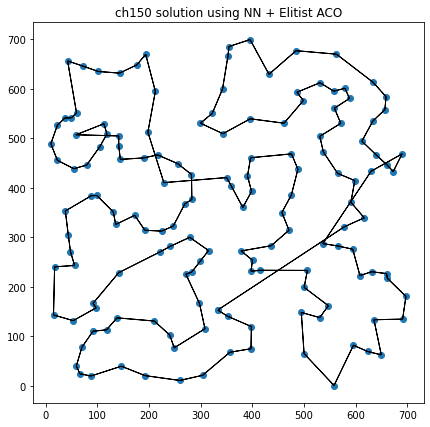

NN + Elitist ACO + 2opt search: Cost =  6620.8 




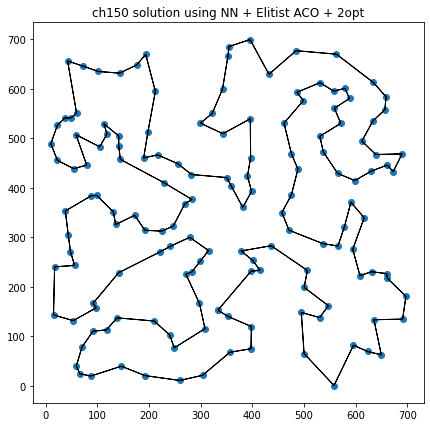

In [ ]:
path_ch150_elitist = elitist.run()
print("NN + Elitist ACO: Cost = ", find_cost(path_ch150_elitist, DS_ch150),"\n\n")
TSP_plot(path_ch150_elitist, map_ch150, "ch150 solution using NN + Elitist ACO")

path_ch150_elitist_2opt = search_2opt(DS_ch150, path_ch150_elitist, 10000)
print("NN + Elitist ACO + 2opt search: Cost = ", find_cost(path_ch150_elitist_2opt, DS_ch150),"\n\n")
TSP_plot(path_ch150_elitist_2opt, map_ch150, "ch150 solution using NN + Elitist ACO + 2opt")